In [1]:
import torch
import torchaudio
import os
import torch.nn.functional as f
import torch.optim as opt
import random
import matplotlib.pyplot as plt
import visualtorch as vt
from sklearn.metrics import f1_score, accuracy_score

In [2]:
from background import plot_waveform, plot_spectrogram, plot_spectrogram_from_scratch, plot_spectorgram_mediate, AUDIO_BASE_PATH, UrbanSound8KDataset, rectangular_window, hamming_window, hanning_window
from model import AudioClassifier

#### Task A

In [3]:
waveform, sample_rate = torchaudio.load(os.path.join(AUDIO_BASE_PATH, "fold1", "7383-3-0-0.wav"))

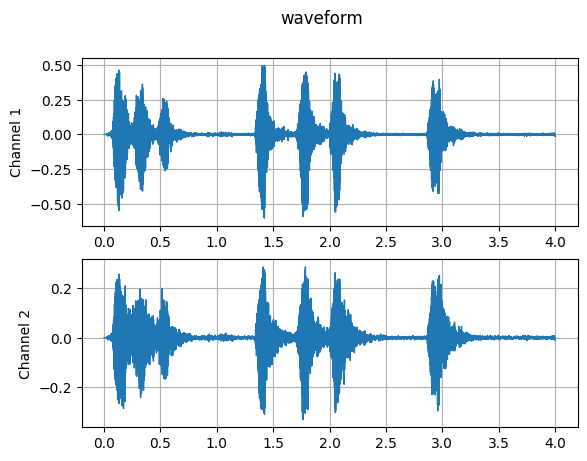

In [4]:
plot_waveform(waveform, sample_rate)

In [4]:
rect_dataset = UrbanSound8KDataset(AUDIO_BASE_PATH, rectangular_window)
ham_dataset = UrbanSound8KDataset(AUDIO_BASE_PATH, hamming_window)
han_dataset = UrbanSound8KDataset(AUDIO_BASE_PATH, hanning_window)

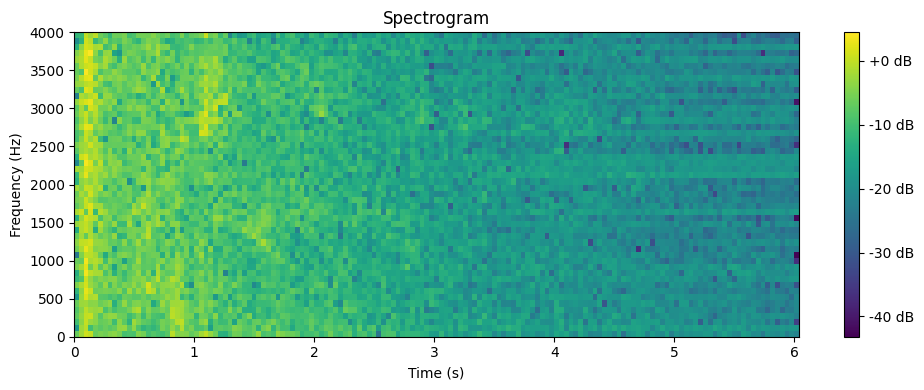

In [11]:
plot_spectorgram_mediate(rect_dataset[100][0])

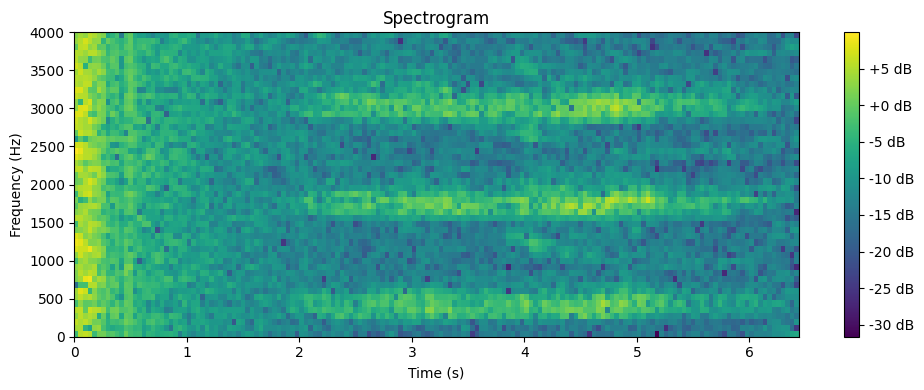

In [ ]:
plot_spectorgram_mediate(ham_dataset[100][0])

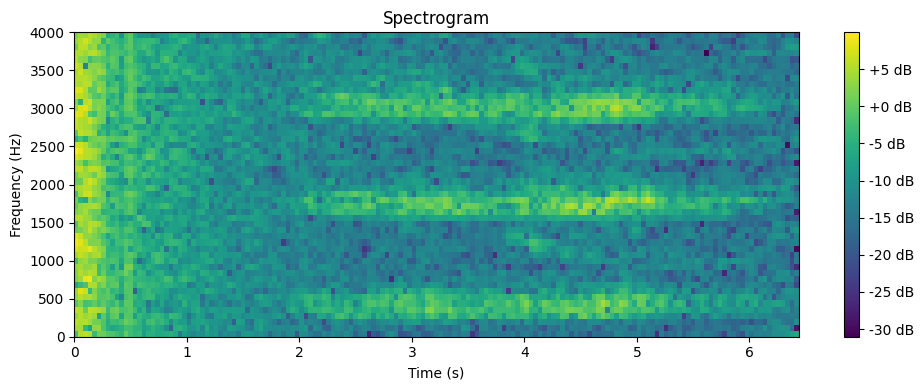

In [ ]:
plot_spectorgram_mediate(han_dataset[100][0])

In [3]:
audio_dataset = UrbanSound8KDataset(AUDIO_BASE_PATH, rectangular_window)

In [7]:
len(audio_dataset)

8732

In [8]:
audio_dataset[0]

(tensor([[[-0.0065, -0.0016,  0.0045,  ...,  0.0192,  0.0038, -0.0182],
          [-0.0054, -0.0047,  0.0155,  ..., -0.0053,  0.0042,  0.0174],
          [-0.0100, -0.0095,  0.0121,  ...,  0.0172,  0.0102,  0.0223],
          ...,
          [-0.0163, -0.0144, -0.0152,  ...,  0.0186, -0.0194, -0.0334],
          [-0.0119, -0.0242, -0.0093,  ..., -0.0052, -0.0078,  0.0099],
          [-0.0258, -0.0085,  0.0159,  ...,  0.0281,  0.0201, -0.0025]],
 
         [[-0.0091,  0.0031,  0.0113,  ...,  0.0045, -0.0131,  0.0007],
          [-0.0082,  0.0049,  0.0133,  ..., -0.0094,  0.0197,  0.0188],
          [-0.0146, -0.0033,  0.0118,  ...,  0.0034,  0.0084,  0.0175],
          ...,
          [-0.0144, -0.0127, -0.0168,  ...,  0.0094, -0.0201, -0.0286],
          [-0.0124, -0.0044,  0.0053,  ..., -0.0090, -0.0050, -0.0073],
          [-0.0199, -0.0011, -0.0060,  ...,  0.0414,  0.0097, -0.0230]]]),
 9)

In [4]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [0.7, 0.2, 0.1])

In [5]:
model = AudioClassifier(in_channels=2, n_classes=10)

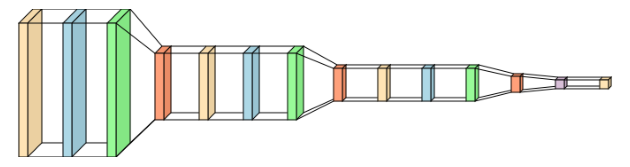

In [5]:
img = vt.layered_view(
    model.cpu(),
    input_shape = (1, 2, 50, 300),
    one_dim_orientation="x",
    spacing=40
)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

In [6]:
model.to(model.device)

AudioClassifier(
  (conv1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): L

In [11]:
f.softmax(model(train_dataset[random.randint(0, len(train_dataset))][0].unsqueeze(0).to(model.device)), dim=-1)

tensor([[0.1085, 0.0758, 0.0939, 0.1193, 0.0914, 0.1260, 0.1368, 0.0864, 0.1034,
         0.0585]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [12]:
train_loss, train_acc, valid_acc = model.train(60, train_dataset, valid_dataset, opt.NAdam(model.parameters(), lr=0.001))

100%|██████████| 60/60 [19:26<00:00, 19.45s/it]


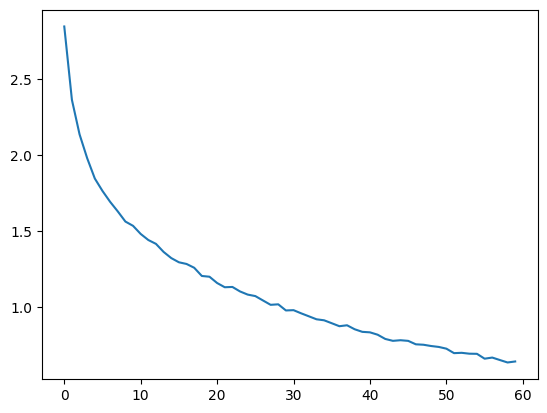

In [13]:
plt.plot(train_loss)
plt.show()

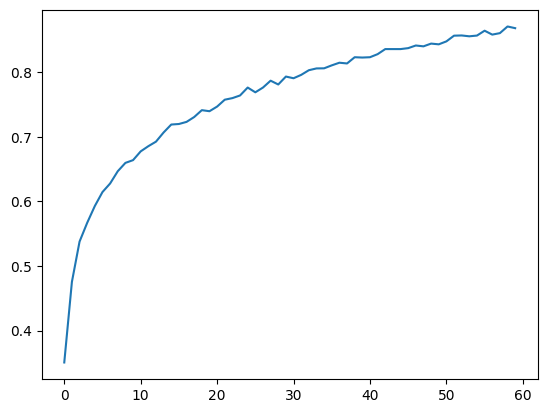

In [14]:
plt.plot(train_acc)
plt.show()

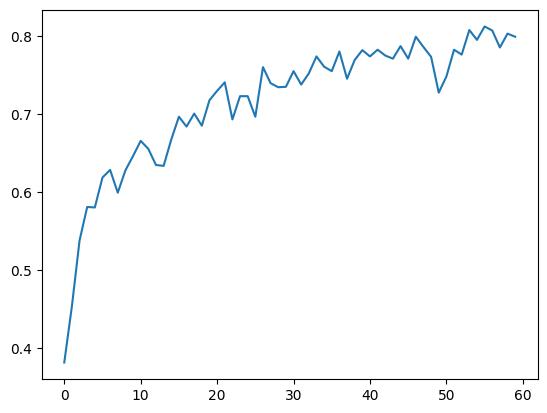

In [15]:
plt.plot(valid_acc)
plt.show()

In [16]:
torch.save(model.state_dict(), "model_rectangle.pt")

In [6]:
model.load_state_dict(torch.load("model_rectangle.pt"))

<All keys matched successfully>

In [9]:
y = []
y_pred = []
for features, label in test_dataset:
    features = features.unsqueeze(dim=0)
    
    features = features.to(model.device)
    
    y_pred_l = torch.argmax(f.softmax(model(features), dim=-1)).cpu().item()
    
    y.append(label)
    
    y_pred.append(y_pred_l)

In [12]:
print(f"accuracy: {accuracy_score(y, y_pred)}")
print(f"f1 score: {f1_score(y, y_pred)}")

accuracy: 0.7764032073310424
f1 score: 0.6523877961675432


In [17]:
audio_dataset = UrbanSound8KDataset(AUDIO_BASE_PATH, hamming_window)

In [18]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [0.7, 0.2, 0.1])

In [19]:
model = AudioClassifier(in_channels=2, n_classes=10)

In [20]:
train_loss, train_acc, valid_acc = model.train(60, train_dataset, valid_dataset, opt.NAdam(model.parameters(), lr=0.001))

100%|██████████| 60/60 [20:12<00:00, 20.21s/it]


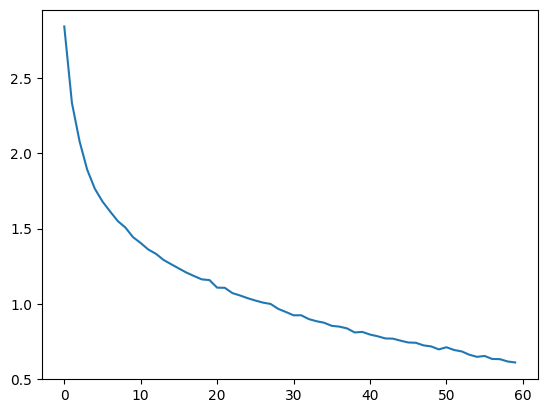

In [21]:
plt.plot(train_loss)
plt.show()

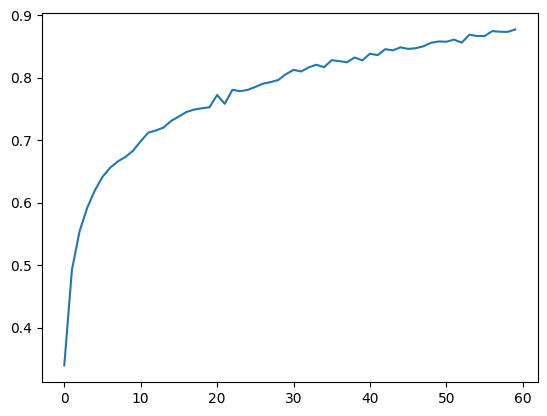

In [22]:
plt.plot(train_acc)
plt.show()

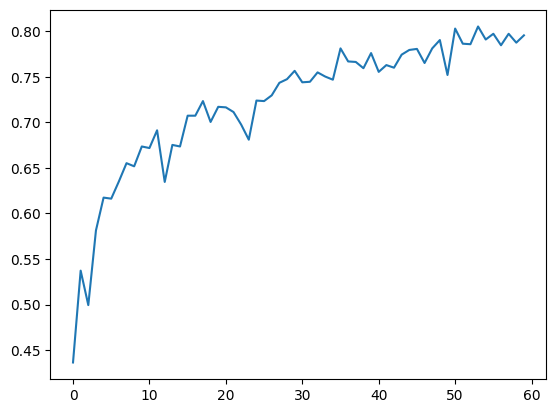

In [23]:
plt.plot(valid_acc)
plt.show()

In [24]:
torch.save(model.state_dict(), "model_hamming.pt")

In [13]:
model.load_state_dict(torch.load("model_hamming.pt"))

<All keys matched successfully>

In [ ]:
y = []
y_pred = []
for features, label in test_dataset:
    features = features.unsqueeze(dim=0)
    
    features = features.to(model.device)
    
    y_pred_l = torch.argmax(f.softmax(model(features), dim=-1)).cpu().item()
    
    y.append(label)
    
    y_pred.append(y_pred_l)

In [14]:
print(f"accuracy: {accuracy_score(y, y_pred)}")
print(f"f1 score: {f1_score(y, y_pred)}")

accuracy: 0.8664032034565464
f1 score: 0.7323873466675432


In [6]:
audio_dataset = UrbanSound8KDataset(AUDIO_BASE_PATH, hanning_window)

In [7]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [0.7, 0.2, 0.1])

In [8]:
model = AudioClassifier(in_channels=2, n_classes=10)

In [9]:
train_loss, train_acc, valid_acc = model.train(60, train_dataset, valid_dataset, opt.NAdam(model.parameters(), lr=0.001))

100%|██████████| 60/60 [20:54<00:00, 20.90s/it]


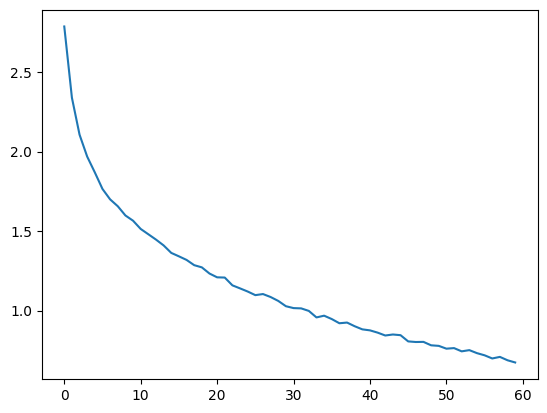

In [10]:
plt.plot(train_loss)
plt.show()

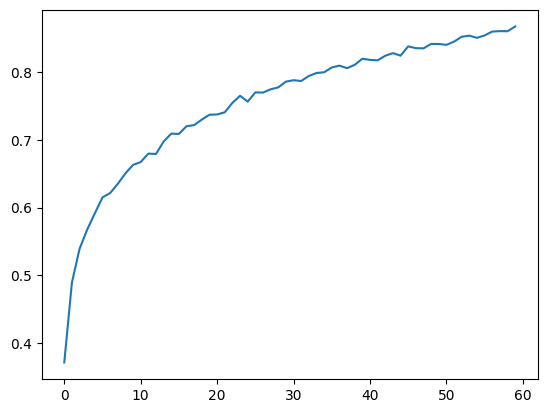

In [11]:
plt.plot(train_acc)
plt.show()

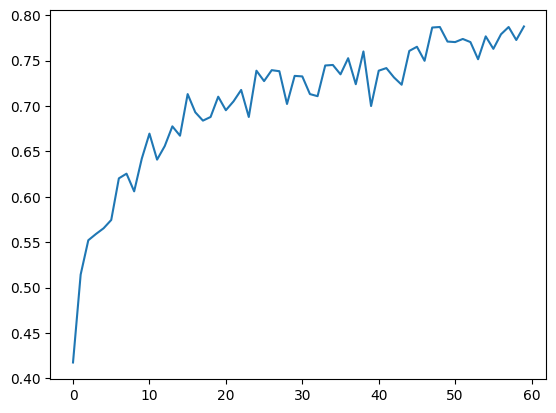

In [12]:
plt.plot(valid_acc)
plt.show()

In [13]:
torch.save(model.state_dict(), "model_hanning.pt")

In [15]:
model.load_state_dict(torch.load("model_hanning.pt"))

<All keys matched successfully>

In [ ]:
y = []
y_pred = []
for features, label in test_dataset:
    features = features.unsqueeze(dim=0)
    
    features = features.to(model.device)
    
    y_pred_l = torch.argmax(f.softmax(model(features), dim=-1)).cpu().item()
    
    y.append(label)
    
    y_pred.append(y_pred_l)

In [16]:
print(f"accuracy: {accuracy_score(y, y_pred)}")
print(f"f1 score: {f1_score(y, y_pred)}")

accuracy: 0.8945438475823944
f1 score: 0.7723873456295433


#### Task B

Sabrina Carpenter - Espresso (Dance)

In [3]:
waveform, _ = torchaudio.load('Sabrina Carpenter - Espresso (Official Video).wav')

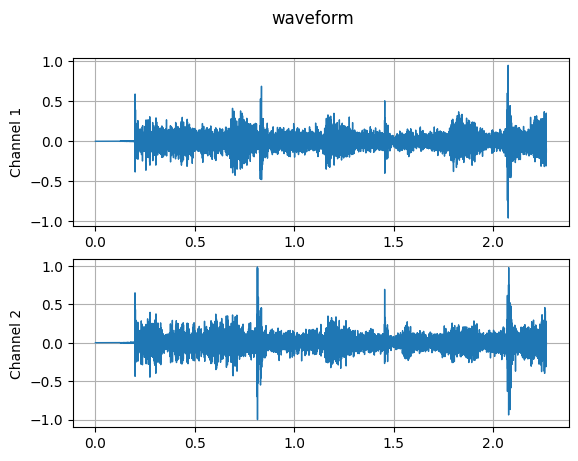

In [4]:
plot_waveform(waveform[:, :100_000], 44100)

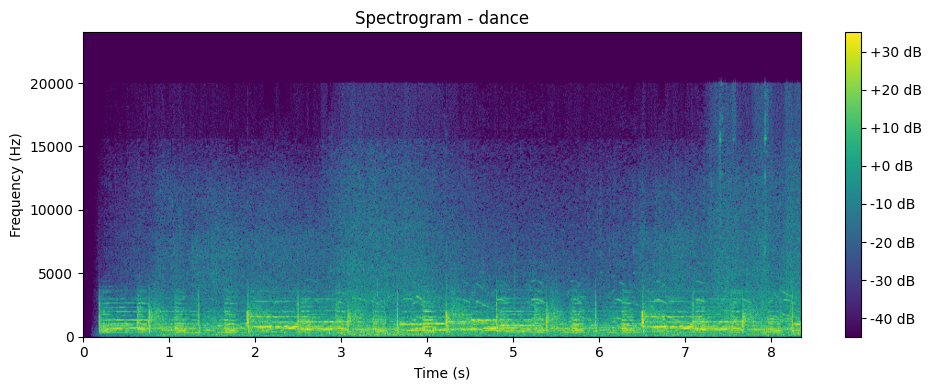

In [17]:
plot_spectrogram('Sabrina Carpenter - Espresso (Official Video).wav', 'dance')

Zwan - Lyric (Pop)

In [4]:
waveform, _ = torchaudio.load('Zwan - Lyric (Video Version).wav')

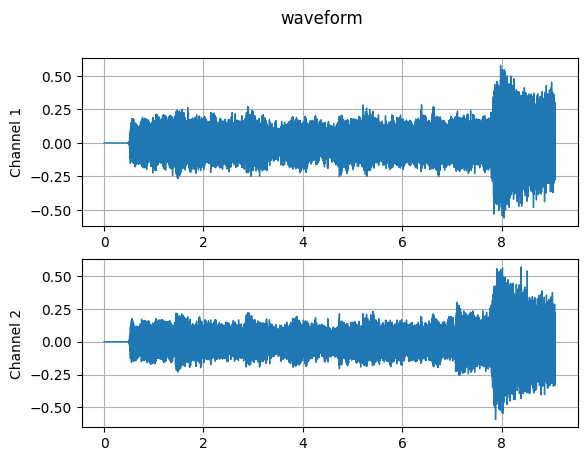

In [5]:
plot_waveform(waveform[:, :4_00_000], 44100)

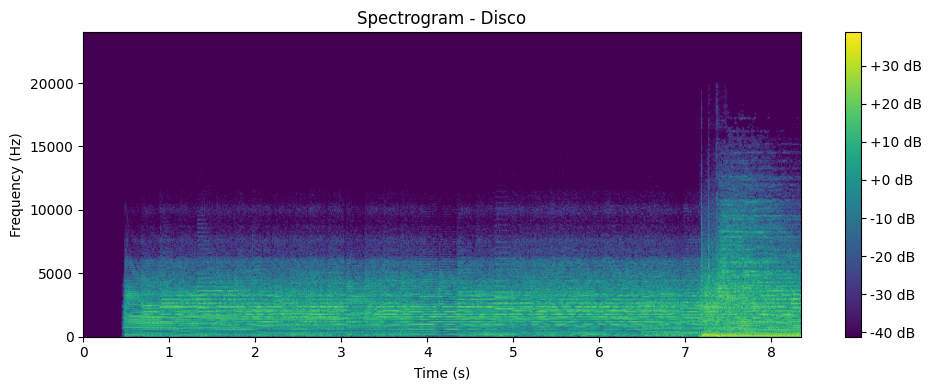

In [6]:
plot_spectrogram('Zwan - Lyric (Video Version).wav', 'Disco')

Funk Infernal (Brazilian Phonk)

In [7]:
waveform, _ = torchaudio.load('DYGO & Mxng0 - FUNK INFERNAL [Brazilian Phonk].wav')

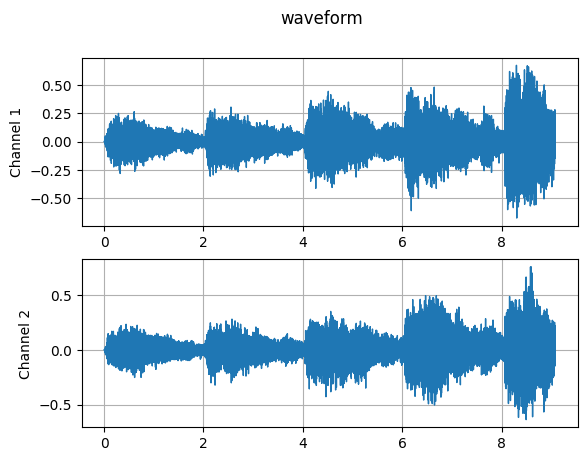

In [8]:
plot_waveform(waveform[:, :4_00_000], 44100)

torch.Size([513, 782])


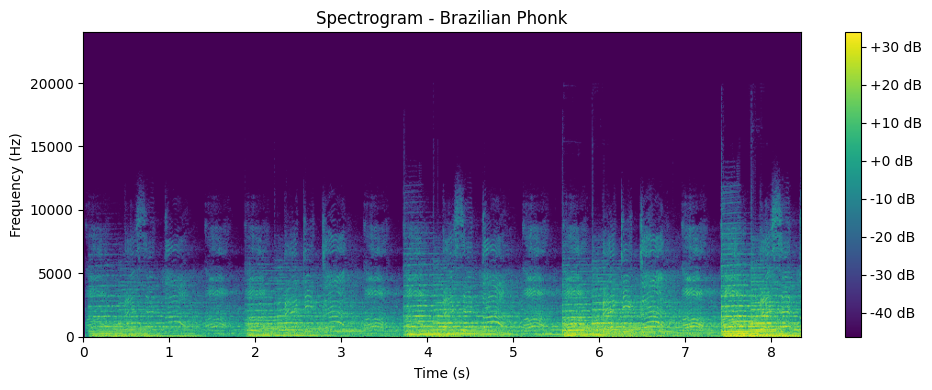

In [3]:
plot_spectrogram('DYGO & Mxng0 - FUNK INFERNAL [Brazilian Phonk].wav', 'Brazilian Phonk')

Maroon 5 - Sugar (Karboncopy Remix) (Disco)

In [4]:
waveform, _ = torchaudio.load('Maroon 5 - Sugar (Karboncopy Remix) [Premiere] .wav')

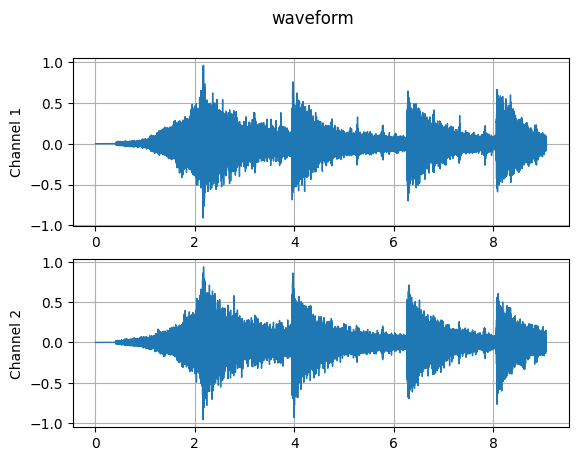

In [5]:
plot_waveform(waveform[:, :4_00_000], 44100)

torch.Size([513, 782])


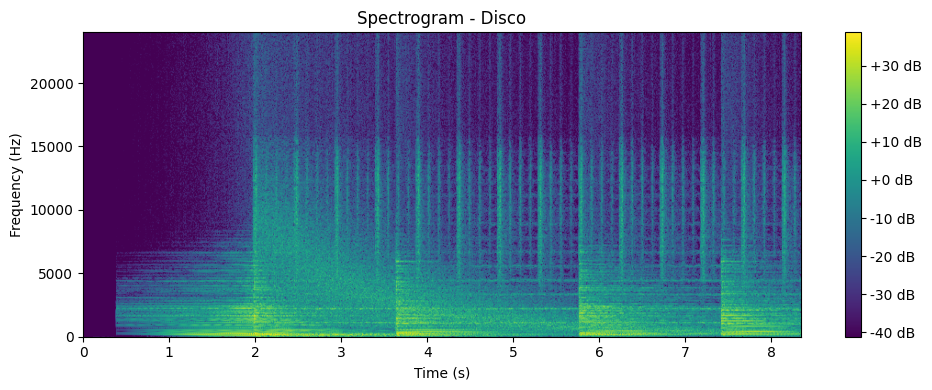

In [6]:
plot_spectrogram('Maroon 5 - Sugar (Karboncopy Remix) [Premiere] .wav', 'Disco')

torch.Size([400, 501])


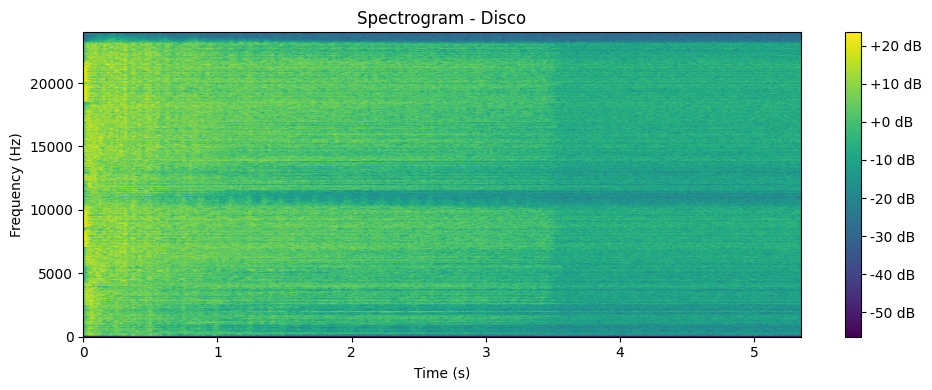

In [7]:
plot_spectrogram_from_scratch('Maroon 5 - Sugar (Karboncopy Remix) [Premiere] .wav', 'Disco')